# Guassian Mixture Model 



In [1]:
import matplotlib.pyplot as plt
import numpy as np

#for normalization + probability density function computation
from scipy import stats

import seaborn as sns
sns.set_style("white")

%matplotlib inline

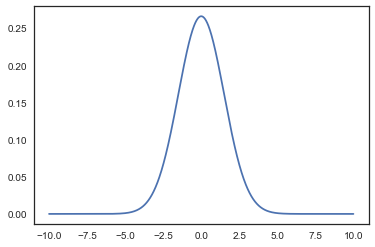

In [2]:
# Return evenly spaced numbers over a specified interval.
x = np.linspace(start=-10, stop=10, num=1000)

# x is a normal continuous random variable.
# The location (loc) keyword specifies the mean. The scale (scale) keyword specifies the standard deviation.
y = stats.norm.pdf(x, loc=0, scale=1.5) 

# plot it!
plt.plot(x, y)

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv('bimodal_example.csv')

df.head(5) # Show first 5 eamples (int BTC)  ==> One feature, one dimensional problem

,x
0,0.252851
1,-1.034562
2,3.319558
3,4.552363
4,-0.775995


In [5]:
# Show the distribution of the data as a histogram
data = df.x

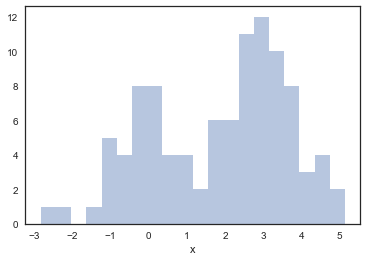

In [6]:
# Plot the histogram 
sns.distplot(data, bins=20, kde=False) # plot a univariate distribution of observations

## Is the normal distribution a useful model for the data?

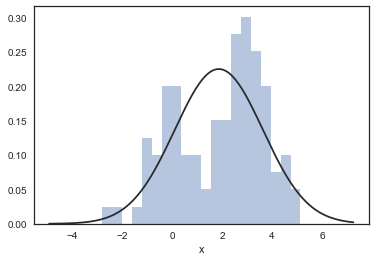

In [7]:
# Try to fit a normal distribution to this data
sns.distplot(data, fit=stats.norm, bins=20, kde=False,)

## Define The Model

Two Normal distributions $N(\mu_1, \sigma_1^2)$ and $N(\mu_2, \sigma_2^2)$.

There are 5 paramaters: 4 of the them are Normal distributions and 1 more for the probability of choosing one of them.

Let $w$ be the probability that the data comes from the first Normal, the parameter in this model is $\theta = (w, \mu_1, \sigma_1^2, \mu_2, \sigma_2^2)$.

The probability density function (PDF) is:
$$f(x | \theta) = w \ f_1(x \ | \ \mu_1, \sigma_1^2) + (1 - w) \ f_2 (x \ | \ \mu_2, \sigma_2^2) $$

## Expectation–Maximization (EM) 

An iterative method for finding maximum likelihood (MLE) or maximum a posteriori (MAP) estimates of parameters in statistical models,when the model depends on unobserved latent variables

   * Expectation (E) step: Given the current parameters of the model, estimate a probability distribution.

   * Maximization (M) step: Given the current data, estimate the parameters to update the model.


The M parameter-estimates are then used to determine the distribution of the latent variables in the next E step.


#### EM is trying to maximize the following function:

    X is directly observed variable
    θ parameters of model
    Z is not directly observed / latent variable
        Z is a joint (related) distribution on x.



## EM Steps  

  1.  Initialize the parameters θ
  2.  Compute the best values for Z given θ
  3.  Use the computed values of Z to compute a better estimate for the θ
  4.  Iterate steps 2 and 3 until convergence


## EM steps, stated another way

   1. Initialize the parameters of the models, either randomly or doing a "smart seeding"

   2. E Step: Find the posterior probabilities of the latent variable given current parameter values.

   3. M Step: Reestimate the parameter values given the current posterior probabilities.

   4. Repeat 2-3 monitoring the likelihood function likelihood. Hope for convergence.


In [8]:
class Gaussian:
    """ Model univariate Gaussian """
    def __init__(self, mu, sigma):
        self.mu = mu   # Mean
        self.sigma = sigma  # Standard deviation
        
    def pdf(self, datum):
        """ Probability of a data point given the current parameters """
        u = (datum - self.mu) / abs(self.sigma)
        y = (1 / (sqrt(2 * pi) * abs(self.sigma))) * exp(-u*u / 2)
        return y
    
    def __repr__(self):
        return 'Gaussian({0:4.6, {1:4.6}})'.format(self.mu, self.sigma)

In [9]:
# Guassian of Best fit
best_single = Gaussian(np.mean(data), np.std(data))
print('Best single Gaussian: μ = {:.2}, σ = {:.2}'.format(best_single.mu, best_single.sigma))

Best single Gaussian: μ = 1.9, σ = 1.8


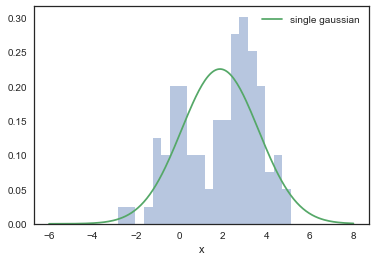

In [10]:
# Fit a single gaussian curve to data
x = np.linspace(-6, 8, 200)
g_single = stats.norm(best_single.mu, best_single.sigma).pdf(x)
sns.distplot(data, bins=20, kde=False, norm_hist=True)
plt.plot(x, g_single, label='single gaussian')
plt.legend()

In [20]:
from math import sqrt, log, exp, pi
from random import uniform

In [21]:
class GaussianMixture:
    """ Model mixture of two univariate Gaussians and their EM estimation """
    def __init__(self, data):
        self.data = data
        
        # Initialize the parameters θ
        mu_min = min(self.data)
        mu_max = max(self.data)
        sigma_min = 0.1
        sigma_max = 1
        mix = 0.5
        
        # Initialize with multiple gaussians
        self.one = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        self.two = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        
        # How much to mix them
        self.mix = mix
        
    """ Basically, you make initial guesses for both the assignments of points to
        distributions and their parameters, and then proceed iteratively.
        Once you have initialized the assignments and parameters, you alternate between the 
        expectation and maximization steps untils your estimates converge (i.e. do not change
        much between iterations; for a mixture of Gaussians this is similar to convergence in k-means)
    """
    
    def E_step(self):
        """ Perform an E-step, freshening up self.loglike in the process """
        # Compute weights 
        self.loglike = 0.
        
        for datum in self.data:
            # unnormalized weights
            wp1 = self.one.pdf(datum) * self.mix
            wp2 = self.two.pdf(datum) * (1. - self.mix)

            # compute denominator
            den = wp1 + wp2 
            if den == 0:
                print wp1, wp2
            wp1 /= den
            wp2 /= den
            
            self.loglike += log(wp1 + wp2)
            
            yield (wp1, wp2)
            
    def M_step(self, weights):
        """ Perform an M-step """
        # Compute denominators 
        (left, right) = zip(*weights)
        one_den = sum(left)
        two_den = sum(right)
        
        # Compute new means 
        self.one.mu = sum(w * d / one_den for (w, d) in zip(left, self.data))
        self.two.mu = sum(w * d / two_den for (w, d) in zip(right, self.data))
        
        # Compute new sigmas
        self.one.sigma = sqrt(sum(w * ((d - self.one.mu) ** 2) for (w, d) in zip(left, self.data)) / one_den)
        self.two.sigma = sqrt(sum(w * ((d - self.two.mu) ** 2) for (w, d) in zip(right, self.data)) / two_den)
        
        # Compute new mix
        self.mix = one_den / len(data)
        
    def iterate(self, N=1, verbose=False):
        """ Perform N iterations, then compute log-likelihood """
        for i in range(1, N+1):
            self.M_step(self.E_step())
            if verbose:
                print('{0:2} {1}'.format(i, self))
        self.E_step() # to freshen up self.loglike
        
    def pdf(self, x):
        return (self.mix) * self.one.pdf(x) + (1 - self.mix) * self.two.pdf(x)
    
    def __repr__(self):
        return 'GaussianMixture({0}, {1}, mix={2.03})'.format(self.one, 
                                                              self.two, 
                                                              self.mix)
    def __str__(self):
        return 'Mixture: {0}, {1}, mix={2:.03})'.format(self.one, 
                                                        self.two, 
                                                        self.mix)
         
                

In [22]:
# Check out the fitting process
n_iterations = 5
best_mix = None
best_loglike = float('-inf')
mix = GaussianMixture(data)
for _ in range(n_iterations):
    try:
        #train!
        mix.iterate(verbose=True)
        if mix.loglike > best_loglike:
            best_loglike = mix.loglike
            best_mix = mix
        
    except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
        pass

In [23]:
# Find best Mixture Gaussian model
n_iterations = 20
n_random_restarts = 500
best_mix = None
best_loglike = float('-inf')
print('Computing best model with random restarts...\n')
for _ in range(n_random_restarts):
    mix = GaussianMixture(data)
    for _ in range(n_iterations):
        try:
            mix.iterate()
            if mix.loglike > best_loglike:
                best_loglike = mix.loglike
                best_mix = mix
        except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
            pass
print('\n\nDone. 🙂')

Computing best model with random restarts...



/Users/michaeliu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':




Done. 🙂


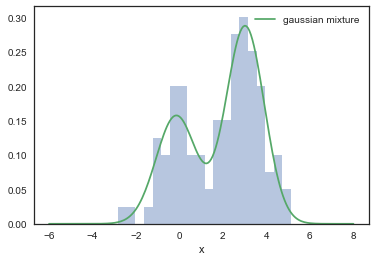

In [24]:
#mixture
sns.distplot(data, bins=20, kde=False, norm_hist=True)
g_both = [best_mix.pdf(e) for e in x]
plt.plot(x, g_both, label='gaussian mixture')
plt.legend()